### <center>Student: *Maksimov Konstantin*</center>

## Description

1. Choose the time period to form the graph
2. Those how are making projects on artilces: half of you need to choose co-authorship graph, others - citation (but consider citation graph as undirected for simplicity)
3. Use weighted graph so that probabilities of infection passing is proportional to the edge weight 

### Data

You need to use data from your project

### Model

Consider SIR-based epidemic model using idea of percolation

Link to source: http://www.leonidzhukov.net/hse/2015/networks/papers/networks-book-ch21.pdf 

### Task

You are in charge of leading the vaccination campaign against some outbroken nonlethal disease. You have options to vactinate or provide medical treatment to infected ones. However, everything has its costs:
* Vaccination of a node costs $500 \$$ and make it immune to the disease all life-long. Unfortunately, you can help this way only to no more than $10\%$ of your nodes
* Medical Treatment costs $120\$$ per day of illness period, which in turn may take from $3$ to $7$ days

Your task is to implement the simulation model, propose some vaccination strategies and compare them (one iteration = one day).

In [206]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import imageio
from random import shuffle
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline

In [134]:
G = nx.read_gpickle("citation3.gpickle")

In [135]:
G = nx.convert_node_labels_to_integers(G)

In [ ]:
pos = nx.spring_layout(G, iterations = 200)

Будем работать с графом цитирования, семплированным из максимальной компоненты связанности соответствующего графа, построенного на наших данных методом ForestFire (метод неплохо сохраняет общую струтуру "леса с лианами" базового графа)

In [278]:
len(G)

50

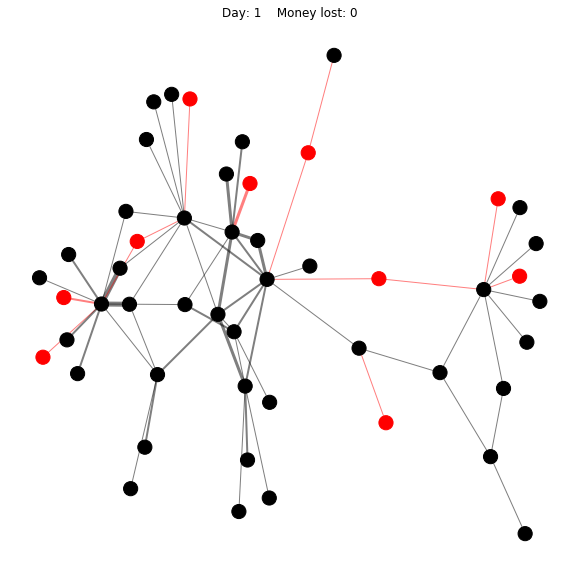

'image1.jpg'

In [260]:
graph_viz(prepare(G), pos = pos)

### Динамическая симуляция

Функция подготовки графа к симуляции:
- Выбираем случайным образом заданное количество инфицированных
- Случайным образом определяем период выздоровления для каждой ноды (3-7 дней)
- Для рёбер в зависимости от веса и заданной базовой вероятности подсчитываем вероятность заражения соседа
- Для каждой вершины подсчитываем математическое ожидание на количество зараженных соседей за итерацию

In [136]:
def prepare(G,inf_number=10,proba=0.1):
    nx.set_edge_attributes(
        G,
        dict(zip(G.edges(), proba * np.array(list(nx.get_edge_attributes(G, "weight").values())))),
        "proba")

    nx.set_node_attributes(
        G,
        dict(zip(G.nodes(), [np.random.choice([3,4,5,6,7]) for _ in range(len(G))])),
        "rec_time")

    infected = dict(zip(G.nodes(), [0 for _ in range(len(G))]))
    for v in np.random.choice(G.nodes(), inf_number, replace=False):
        infected[v] = 1
    nx.set_node_attributes(G, infected, "status")
    
    importance = dict(zip(G.nodes(), [sum([G[p][n]["proba"]
                                           for p in nx.neighbors(G, n)]) for n in G.nodes]))
    nx.set_node_attributes(G, importance, "importance")

    return G

Функция визуализации:
- Чёрные ноды - ещё не переболевшие 
- Красные - инфицированные
- Оранжевые - вакцинированные
- Зелёные - переболевшие
  
- Толщина рёбер отражает их вес

In [137]:
def graph_viz(G, pos, day_count = 1, budget_count = 0):
    colors = ['black', 'red', 'green', 'orange', 'gray']
    col = []
    col_e = []
    for n in list(G.nodes()):
        col.append(colors[G.nodes[n]["status"]])
    for e in list(G.edges()):
        if (G.nodes[e[0]]["status"] == 1 or
            G.nodes[e[1]]["status"] == 1):
            col_e.append(colors[1])
        else:
            col_e.append(colors[0])
        if (G.nodes[e[0]]["status"] == 2 or
            G.nodes[e[1]]["status"] == 2):
            col_e[-1] = colors[4]
    time.sleep(0.5)
    clear_output(True)
    plt.figure(figsize=(10,10))
    plt.title("Day: " + str(day_count) + "    Money lost: " + str(budget_count))
    nx.draw_networkx_nodes(G, node_size = 200, node_color = col, pos=pos, )
    nx.draw_networkx_edges(G,pos=pos, alpha = 0.5,
                           width = list(nx.get_edge_attributes(G, "weight").values()),
                           edge_color = col_e)
    plt.box(False)
    plt.tick_params(top='off', bottom='off', left='off',
                    right='off', labelleft='off', labelbottom='off')
    im_file = 'image' + str(day_count) + '.jpg'
    plt.savefig(im_file)
    plt.show()
    return im_file

Сохраняем анимацию:

In [138]:
def create_gif(gif_name, file_names, duration=0.5):
    images = []
    for f in file_names:
        images.append(imageio.imread(f))
    imageio.mimsave(gif_name, images, duration=duration)

Функция симуляции:
- При каждой итерации по вероятностям определяем новых зараженных
- В конце кажлого дня применяем выбранную стратегию

In [254]:
def simulation(G, strategy = strategy_0, inf_number=10, proba = 0.1, viz = True, pos=pos):
    G = prepare(G,inf_number, proba)
    day_count = 1
    budget_count = 0

    if viz:
        im_files = []
        im_files.append(graph_viz(G, pos, day_count, budget_count))

    while 42:
        budget_count = strategy(G, budget_count, vac_num = int(0.1 * len(G)))

        infected = set()
        for v in G.nodes:
            if G.nodes[v]["status"] == 1:
                infected.add(v)

        for i in infected:
            G.nodes[i]["rec_time"] -= 1
            budget_count += 120
            
            for neib in nx.neighbors(G, i):
                if (G.nodes[neib]["status"] == 0 and
                    random.random() < G[i][neib]["proba"]):
                    G.nodes[neib]["status"] = 1

            if G.nodes[i]["rec_time"] <= 0:
                G.nodes[i]["status"] = 2

        day_count +=1
        if viz:
            im_files.append(graph_viz(G, pos, day_count, budget_count))
        if not(infected):
            break
    if viz:
        create_gif('Gif_' + datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S') + '.gif',
                   im_files,
                   duration=0.8)
    return budget_count

**Базовая стратегия:** Лечим всех зараженных, вакцинация не применяется (поскольку самолечения нету, задерживать лечение не имеет смысла)

In [166]:
def strategy_0(G, budget_count, vac_num = 5):
    return budget_count

<img style="float: left;" src="Gif_2019_03_17_05_34_01.gif">

**Простая стратегия:** В первый день случайно выбираем максимально доступное число заразившихся (не более 10% популяции) и вакцинируем их

In [198]:
def strategy_1(G, budget_count, vac_num = 5):
    vaccinated = 0
    for n in G.nodes:
        if G.nodes[n]["status"] == 3:
            vaccinated += 1
            
    nodes = list(G.nodes())
    shuffle(nodes)
    vacant = 0
    for n in nodes:
        if vaccinated == vac_num:
            break
        if G.nodes[n]["status"] != 1:
            continue
        budget_count += 500
        vaccinated += 1
        G.nodes[n]["status"] = 3

    return budget_count

<img style="float: left;" src="Gif_2019_03_17_05_49_48.gif">

**Улучшенная стратегия:** каждый день подсчитываем для вершин математическоео ожидание на число потенциально зараженных, выбираем вершины с максимальной величиной в количестве равном числу оставшихся вакцин и вакцинируем их, если такая вершина заражена или соседствует с зараженной

In [195]:
def strategy_2(G, budget_count, vac_num = 5):
    vaccinated = 0
    for n in G.nodes:
        if G.nodes[n]["status"] == 3:
            vaccinated += 1
            
    importance = dict(zip(G.nodes(), [sum([G[p][n]["proba"] * (G.nodes[p]["status"] == 0)
                                           for p in nx.neighbors(G, n)]) for n in G.nodes]))
    vacant = 0
    for i, _ in sorted(importance.items(), key=lambda x: (-x[1],x[0])):
        if vaccinated >= vac_num:
            break
        if G.nodes[i]["status"] > 1:
            continue
        for n in nx.neighbors(G, i):
            if G.nodes[n]["status"] == 1:
                if G.nodes[i]["status"] == 1:
                    budget_count += (500 - 120)
                if G.nodes[i]["status"] == 0:
                    budget_count += 500
                G.nodes[i]["status"] = 3
                vaccinated += 1
                break
        vacant += 1 
        if vacant == vac_num:
            break
    return budget_count

<img style="float: left;" src="Gif_2019_03_17_05_56_41.gif">

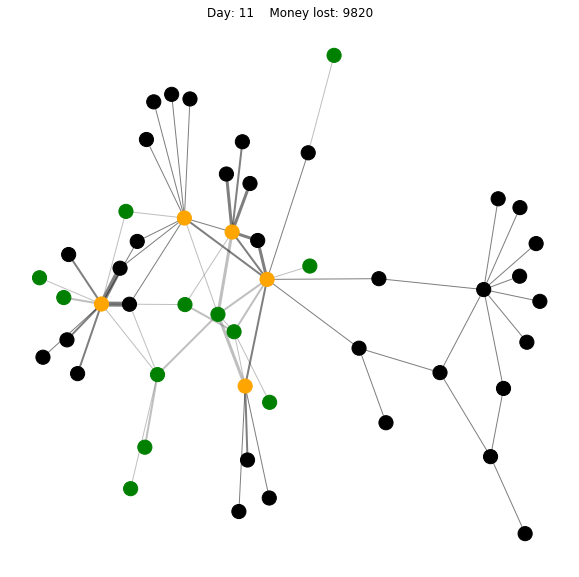

9820

In [277]:
simulation(G, strategy_2, inf_number=10, proba = 0.2, viz = True)

Функция оценки бюджета для выбранной стратегии на выбранных параметрах:
- Усредняет результаты большого числа тестирований
- Вносит некоторую случайность в базовые параметры для более репрезентативного результата

In [238]:
def metric(G, strategy, inf_number, proba, num):
    frame = []
    for _ in range(num):
        frame.append(simulation(G,
                                strategy,
                                inf_number = int(inf_number * (2 + random.random()) / 3),
                                proba = proba * (1 + random.random()) / 2,
                                viz = False))
    return int(np.array(frame).mean())

Теперь протестируем стратегии на разных сочетаниях базовой вероятности заражения и начального числа зараженных:

In [297]:
res0 = {}
res1 = {}
res2 = {}

for inf_number in tqdm([5, 10, 15, 25]):
    for proba in [0.1, 0.2, 0.35, 0.5]:
        res0["n = " + str(inf_number) + ", p = " + str(proba)] = metric(G, strategy_0, inf_number, proba, num = 1000)
        res1["n = " + str(inf_number) + ", p = " + str(proba)] = metric(G, strategy_1, inf_number, proba, num = 1000)
        res2["n = " + str(inf_number) + ", p = " + str(proba)] = metric(G, strategy_2, inf_number, proba, num = 1000)

100%|███████████████████████████████████████████| 4/4 [07:08<00:00, 104.65s/it]


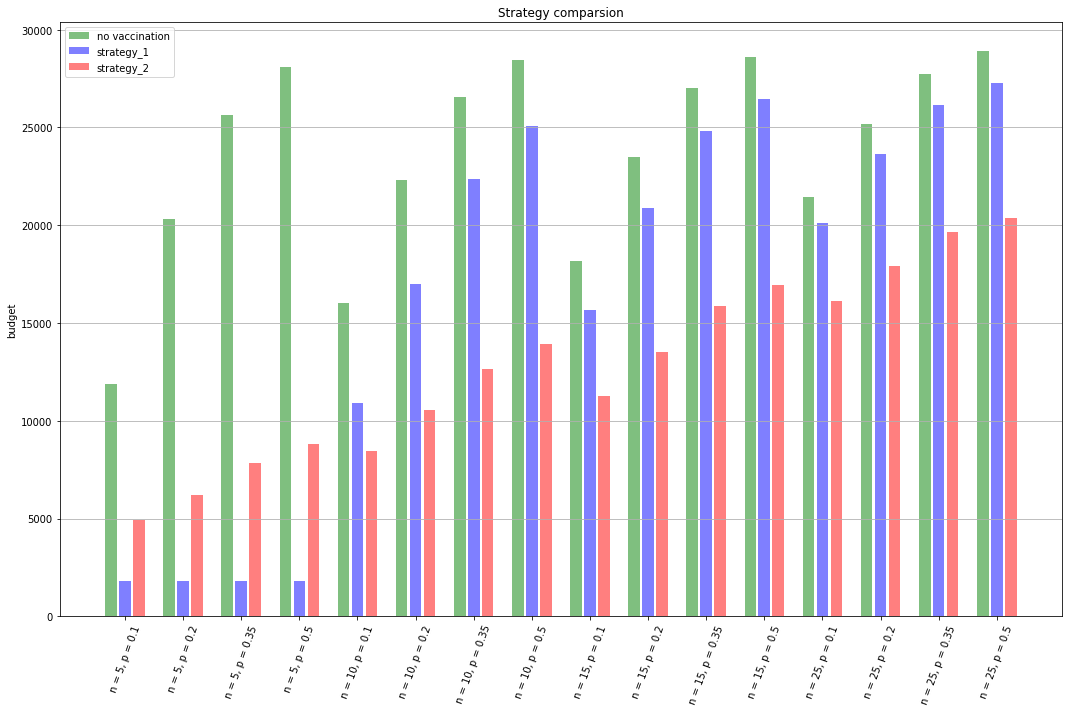

In [298]:
plt.figure(figsize=(15,10))

index = np.arange(len(res))
bar_width = 0.2
opacity = 0.5

plt.bar(index - 1.2*bar_width, list(res0.values()), bar_width,
                 alpha=opacity,
                 color='g',
                 label='no vaccination')

plt.bar(index, list(res1.values()), bar_width,
                 alpha=opacity,
                 color='b',
                 label='strategy_1')


plt.bar(index + 1.2*bar_width, list(res2.values()), bar_width,
                 alpha=opacity,
                 color='r',
                 label='strategy_2')
 
plt.ylabel(u"budget")
plt.title(u"Strategy comparsion")
plt.xticks(index, np.array(list(res0.keys())), rotation=70)
plt.legend()
plt.grid(axis='y')
 

plt.tight_layout()
plt.show()

Визуализируем полученные данные:

- Видим, что для числа начальных зараженных не превышающего 10% общего числа нод, тактика вакцинации первых зараженных (strategy_1) ожидаемо даёт идеальный результат.
- При увелечении же этого порога результат приближается к базовой стратегии, и при численности нулевых пациентов порядка половины популяции, практически с ней сравнивается.
- Улучшенная же стратегия (strategy_2) показывает стабильное превосходство над базовой при всех начальных условиях.
- Очевидным решением по дальнейшему развитию может стать объединение сильных сторон двух стратегий по принципу выбора в зависимости от начального числа зараженных относительно 10% порога.

### Симуляция с percolation
Период восстановления мы уже считаем заранее, посмотрим, что изменится, если заранее определить и проходимость рёбер.  
  
Для неориентированного графа учесть зависимость проходимости ребра от периода выздоровления его вершин не представляется возможным (две вершины могут иметь разный период, а значит в идеале проходимость в разные стороны может отличаться), поэтому будем считать, что вершины после первого дня попадают в карантин.

In [289]:
def prepare_perc(G,inf_number=10,proba=0.1):
    nx.set_edge_attributes(
        G,
        dict(zip(G.edges(), proba * np.array(list(nx.get_edge_attributes(G, "weight").values())))),
        "proba")
    for e in G.edges():
        if random.random() < G.edges()[e]["proba"]:
            G.edges()[e]["proba"] = 1
        else:
            G.edges()[e]["proba"] = 0

    nx.set_node_attributes(
        G,
        dict(zip(G.nodes(), [np.random.choice([3,4,5,6,7]) for _ in range(len(G))])),
        "rec_time")

    infected = dict(zip(G.nodes(), [0 for _ in range(len(G))]))
    for v in np.random.choice(G.nodes(), inf_number, replace=False):
        infected[v] = 1
    nx.set_node_attributes(G, infected, "status")
    
    importance = dict(zip(G.nodes(), [sum([G[p][n]["proba"]
                                           for p in nx.neighbors(G, n)]) for n in G.nodes]))
    nx.set_node_attributes(G, importance, "importance")

    return G

In [290]:
def simulation_perc(G, strategy = strategy_0, inf_number=10, proba = 0.1, viz = True, pos=pos):
    G = prepare_perc(G,inf_number, proba)
    day_count = 1
    budget_count = 0

    if viz:
        im_files = []
        im_files.append(graph_viz(G, pos, day_count, budget_count))

    while 42:
        budget_count = strategy(G, budget_count, vac_num = int(0.1 * len(G)))

        infected = set()
        for v in G.nodes:
            if G.nodes[v]["status"] == 1:
                infected.add(v)

        for i in infected:
            G.nodes[i]["rec_time"] -= 1
            budget_count += 120
            
            for neib in nx.neighbors(G, i):
                if (G.nodes[neib]["status"] == 0 and
                    1 == G[i][neib]["proba"]):
                    G.nodes[neib]["status"] = 1

            if G.nodes[i]["rec_time"] <= 0:
                G.nodes[i]["status"] = 2

        day_count +=1
        if viz:
            im_files.append(graph_viz(G, pos, day_count, budget_count))
        if not(infected):
            break
    if viz:
        create_gif('Gif_' + datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S') + '.gif',
                   im_files,
                   duration=0.8)
    return budget_count

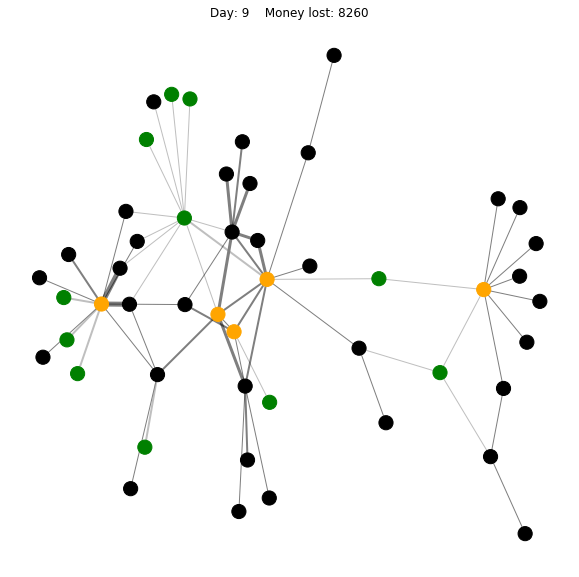

8260

In [291]:
simulation_perc(G, strategy_2, inf_number=10, proba = 0.2, viz = True)

<img style="float: left;" src="Gif_2019_03_17_06_50_12.gif">

In [292]:
def metric_perc(G, strategy, inf_number, proba, num):
    frame = []
    for _ in range(num):
        frame.append(simulation_perc(G,
                                     strategy,
                                     inf_number = int(inf_number * (2 + random.random()) / 3),
                                     proba = proba * (1 + random.random()) / 2,
                                     viz = False))
    return int(np.array(frame).mean())

- Поскольку мы теперь не учитываем период выздоровления в вероятности заражения, то по сути все вероятности заражения стали меньше, поэтому для тестов сдвинем диапазон вероятностей в большую сторону:

In [299]:
res0 = {}
res1 = {}
res2 = {}

for inf_number in tqdm([5, 10, 15, 25]):
    for proba in [0.2, 0.3, 0.45, 0.6]:
        res0["n = " + str(inf_number) + ", p = " + str(proba)] = metric_perc(G, strategy_0, inf_number, proba, num = 1000)
        res1["n = " + str(inf_number) + ", p = " + str(proba)] = metric_perc(G, strategy_1, inf_number, proba, num = 1000)
        res2["n = " + str(inf_number) + ", p = " + str(proba)] = metric_perc(G, strategy_2, inf_number, proba, num = 1000)

100%|████████████████████████████████████████████| 4/4 [04:24<00:00, 65.07s/it]


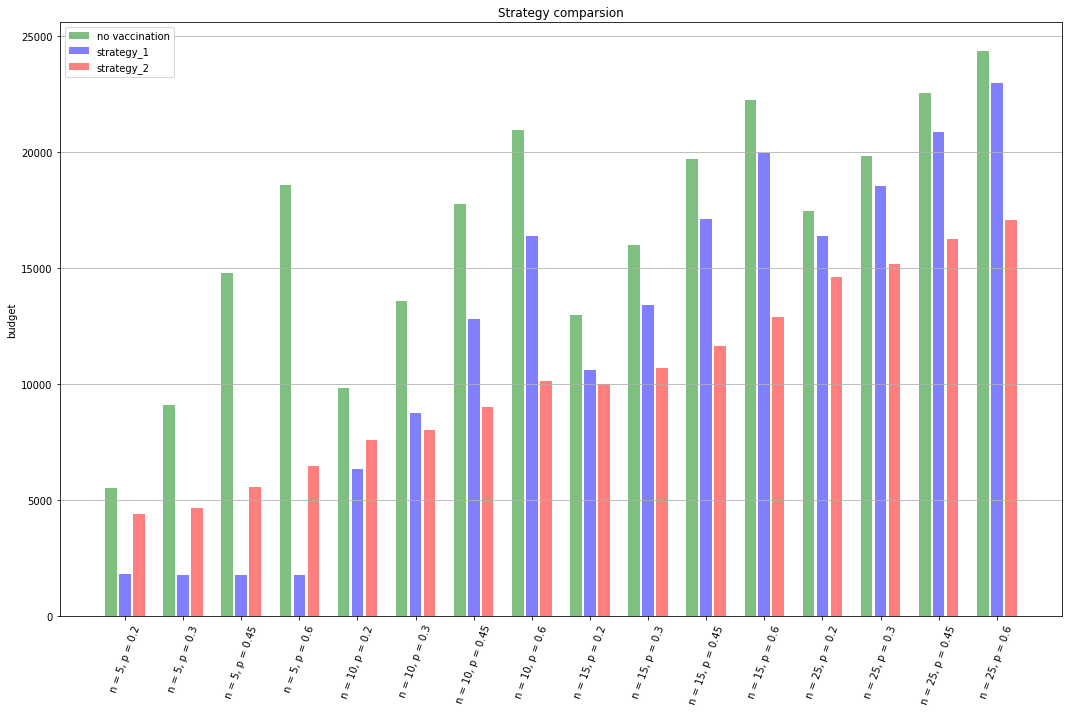

In [300]:
plt.figure(figsize=(15,10))

index = np.arange(len(res))
bar_width = 0.2
opacity = 0.5

plt.bar(index - 1.2*bar_width, list(res0.values()), bar_width,
                 alpha=opacity,
                 color='g',
                 label='no vaccination')

plt.bar(index, list(res1.values()), bar_width,
                 alpha=opacity,
                 color='b',
                 label='strategy_1')


plt.bar(index + 1.2*bar_width, list(res2.values()), bar_width,
                 alpha=opacity,
                 color='r',
                 label='strategy_2')
 
plt.ylabel(u"budget")
plt.title(u"Strategy comparsion")
plt.xticks(index, np.array(list(res0.keys())), rotation=70)
plt.legend()
plt.grid(axis='y')
 

plt.tight_layout()
plt.show()

- С поправкой на наше допущение с карантином, результаты явно похожи на результаты динамической симуляции